# Okabe Equation Impl.

## Sample Dataset

### Stations

In [1]:
import numpy as np

stations_np = np.array(
    np.meshgrid(
        range(0, 20001, 400),
        range(0, 20001, 400),
        [0.1]), dtype='float32').T.reshape(-1, 3)

stations_np.shape

(2601, 3)

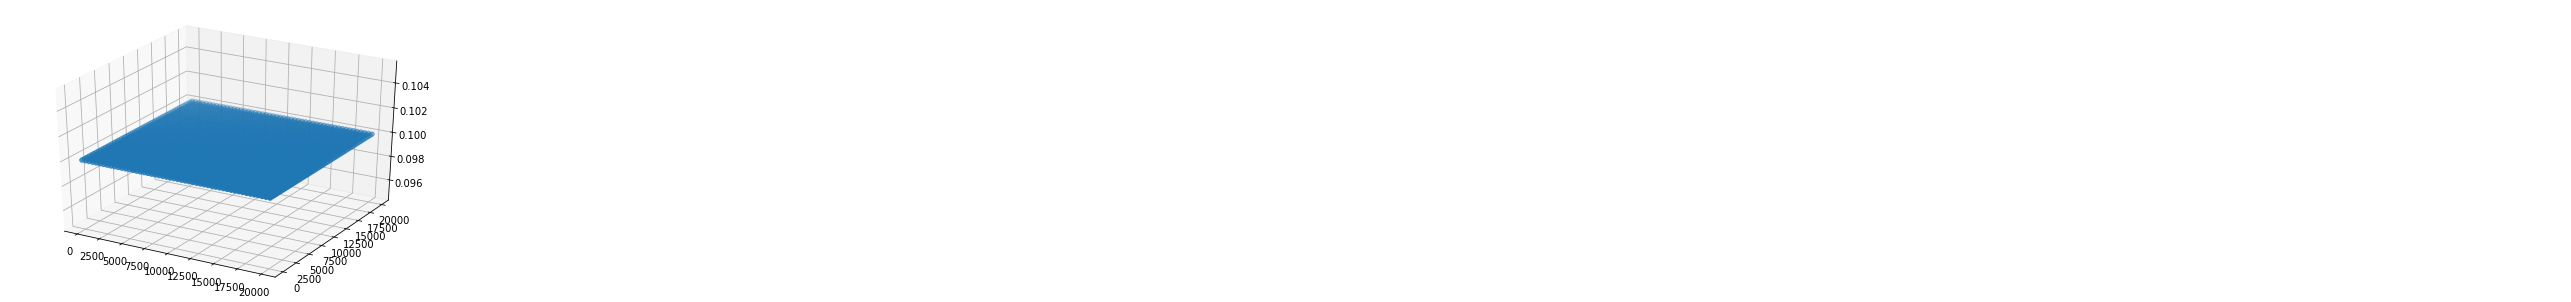

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.scatter(stations_np[:, 0], stations_np[:, 1], stations_np[:, 2])

### Prisms

#### Mu Constants

In [3]:
from itertools import product

import numpy as np

d_sets = [d for d in product((0., 1., ), repeat=3)]

mus_np = np.prod(
    np.power(-1, np.asarray(d_sets, dtype='float32') + 1), axis=1)
mus_np

array([-1.,  1.,  1., -1.,  1., -1., -1.,  1.])

#### Locations, Indices, Rhos

In [4]:
import numpy as np

# Primitive gen.
def gen_locations(xs, ys, zs):
    return np.array(
        np.meshgrid(xs, ys, zs), dtype='float32').T.reshape(-1, 3)

def gen_rhos(n, rho_val):
    return np.full((n, ), rho_val, dtype='float32')

def gen_indices_list(n_xs, n_ys, n_zs, base_i=0):
    indices = []
    
    for xi in range(0, n_xs - 1):
        for yi in range(0, n_ys - 1):
            for zi in range(0, n_zs - 1):
                i_set = []
                for d_set in d_sets:
                    dxi, dyi, dzi = d_set
                    
                    i = yi + dyi
                    i += (xi + dxi) * n_ys
                    i += (zi + dzi) * n_ys * n_xs
                    i_set.append(base_i + i)
                indices.append(tuple(i_set))
    
    return np.asarray(indices, dtype='int32')

# Prism gen.
def concat_prisms(xs, ys, zs, rho_val, prev_locs=None, prev_indices=None, prev_rhos=None):
    locs = gen_locations(xs, ys, zs)
    indices = gen_indices_list(
        len(xs), len(ys), len(zs),
        base_i=len(prev_locs) if prev_locs is not None else 0)
    rhos = gen_rhos(len(indices), rho_val)
    
    if prev_locs is not None:
        locs = np.concatenate((prev_locs, locs, ))
    if prev_indices is not None:
        indices = np.concatenate((prev_indices, indices, ))
    if prev_rhos is not None:
        rhos = np.concatenate((prev_rhos, rhos, ))
    
    return (locs, indices, rhos, )

# Generate instances
prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(8500, 13501+500, 500),
    range(1500, 14001+500, 500),
    range(1500, 1751+250, 250),
    2180.)

prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(8500, 17501+500, 500),
    range(1500, 14001+500, 500),
    range(2000, 3251+250, 250),
    2180.,
    prism_locs_np, prism_indices_np, prism_rhos_np)

prism_locs_np, prism_indices_np, prism_rhos_np = concat_prisms(
    range(3000, 5001+500, 500),
    range(4000, 13001+500, 500),
    range(2000, 2501+250, 250),
    2180.,
    prism_locs_np, prism_indices_np, prism_rhos_np)

prism_locs_np.shape

(5232, 3)

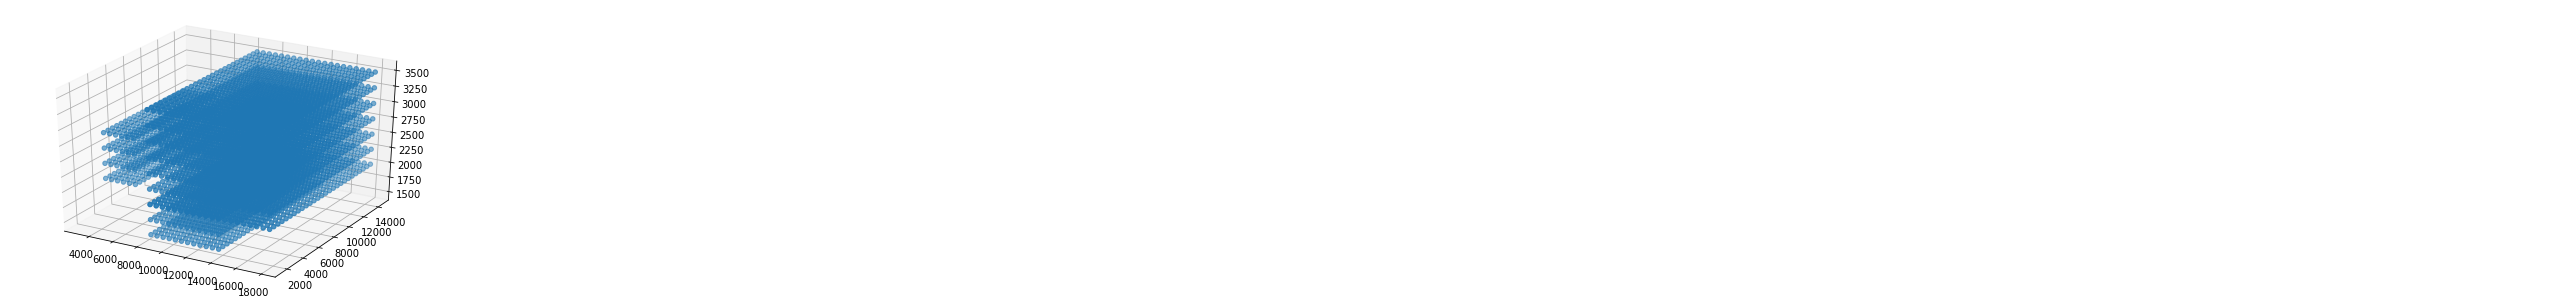

In [5]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# c = ["blue" if (i in prism_indices_np[2499]) else "red" for i in range(0, len(prism_locs_np))]

ax = Axes3D(plt.figure())
ax.scatter(prism_locs_np[:, 0], prism_locs_np[:, 1], prism_locs_np[:, 2])

## Calculation

### Tools

In [6]:
import tensorflow as tf

def pairwise_dist(a, b):
    with tf.variable_scope('pairwise_dist'):
        na = tf.reduce_sum(tf.square(a), axis=1)
        nb = tf.reduce_sum(tf.square(b), axis=1)
        
        na = tf.reshape(na, (-1, 1))
        nb = tf.reshape(nb, (1, -1))
        
        d = tf.sqrt(na - 2*tf.matmul(a, b, transpose_b=True) + nb)
    return d

### Generate Dataflow

In [7]:
import tensorflow as tf

# Prepare stations
stations = tf.convert_to_tensor(stations_np)
stations_x_vert = stations[:, 0:1]
stations_y_vert = stations[:, 1:2]
stationz_z_vert = stations[:, 2:3]

# Prepare prisms
prism_locs = tf.convert_to_tensor(prism_locs_np)
prism_locs_x = prism_locs[:, 0]
prism_locs_y = prism_locs[:, 1]
prism_locs_z = prism_locs[:, 2]

mus = tf.convert_to_tensor(mus_np)

prism_indices = tf.convert_to_tensor(prism_indices_np)
prism_rhos = tf.convert_to_tensor(prism_rhos_np)

# Pairwise distances between stations and locations
rs = pairwise_dist(stations, prism_locs)

# Calculate Okabe properties per locations
dxs = stations_x_vert - prism_locs_x
dys = stations_y_vert - prism_locs_y
dzs = stationz_z_vert - prism_locs_z

dys_rs = dys + rs

os = (dxs + dys_rs) / dzs
ds_no_mu = dxs*tf.log(dys_rs) + dys*tf.log(dxs+rs) + 2*dzs*tf.atan(os)

# Apply Mu constants
prisms_ds_no_mu = tf.gather(ds_no_mu, prism_indices, axis=1)
mus_depth = tf.reshape(mus, (1, 1, mus.get_shape()[0]))

prisms_ds = prisms_ds_no_mu * mus_depth

# Sum d-values of 8 locations for prisms
prisms_d = tf.reduce_sum(prisms_ds, axis=2)

# Gather reference points
prism_zs = tf.gather(prism_locs_z, prism_indices[:, 0])
prism_zs

# Calculate station values
mnk_const = -6.67384 * 10**-6

prisms_r = prism_rhos - (1400.0 + (172.0 * prism_zs**0.21))
prisms_g = mnk_const * prisms_r * prisms_d

stations_g = tf.reduce_sum(prisms_g, axis=1)
stations_g

<tf.Tensor 'Sum_1:0' shape=(2601,) dtype=float64>

### Calculate

In [8]:
import tensorflow as tf

with tf.Session() as session:
    %time out = session.run(stations_g)
out

CPU times: user 11.6 s, sys: 30.4 s, total: 42 s
Wall time: 30.5 s


array([-0.16402179, -0.17317302, -0.18288419, ..., -0.25666277,
       -0.23469407, -0.21502   ])

In [10]:
import pandas as pd

pd.DataFrame(out).to_csv('out.csv')